# W207.6 Final Project - Predicting Cancer Type from Tumor Mutations
### Tony Di Sera, Vijay Singh, Rajiv Nair, Jeremey Fraenkel


# Initialization

In [0]:
import pandas as pd
import urllib.request
import numpy as np
import glob
import os
import warnings
from textwrap import wrap
import matplotlib.pyplot as plt
from IPython.display import display
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.preprocessing import label_binarize

plt.rcParams.update({'figure.max_open_warning': 0})

# Establish the colors for each cancer type
label_colors = []
cm = plt.get_cmap('tab20b')
for i in range(20):
    label_colors.append(cm(i))
cm = plt.get_cmap('tab20c')
for i in range(13):
    label_colors.append(cm(i))

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
cd /content/drive/My Drive/berkeley/W207 machine learning/Final Project/w207_6_sum19_g5_final_project/final_notebooks

/content/drive/My Drive/berkeley/W207 machine learning/Final Project/w207_6_sum19_g5_final_project/final_notebooks


In [4]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [0]:
# create the directory where the downloaded directory is stored
data_dir = "./data"
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
# create the directory where the metrics are stored
metrics_dir = "./metrics"
if not os.path.isdir(metrics_dir):
    os.makedirs(metrics_dir)
    
# create the raw where the source data is stored
raw_dir = "./raw"
if not os.path.isdir(raw_dir):
    os.makedirs(raw_dir)    

### The data dictionary
All data source files are downloaded above.  This dataset, is a data dictionary
that will allow us to translate cancer type codes to cancer type names.

In [6]:
# This downloads a dictionary file
dictionary_filename = "./raw/tcga_dictionaries.txt"
if os.path.isfile(dictionary_filename):
    print("Skipping download, as file %s is present" %(dictionary_filename))
else:
    print('Downloading dictionary file...')
    url = 'https://w207-final-project.s3.amazonaws.com/raw/tcga_dictionaries.txt'  
    urllib.request.urlretrieve(url, dictionary_filename)  
print("done.")


# This loads the data dictionary to will convert
# the tumor_sample_barcode into a cancer_type
# and provide full names for the cancer types
tcga_dict = open("./raw/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 4:
        tissue_source_site = eval(line)            
    elif dict_name_index == 5:
        code_to_disease = eval(line)
    elif dict_name_index == 6:
        disease_to_code = eval(line)

Skipping download, as file ./raw/tcga_dictionaries.txt is present
done.


# Run the Classifiers

## Load the data

In [0]:
def getDataAndLabels(name, features, label_encoder):
    labels_string = features.cancer_type
   
    labels        = label_encoder.fit_transform(labels_string)

    # Get rid of the cancer type and patient_barcode columns 
    data = features[features.columns[3:]]

    return {'name': name, 'feature_size': data.shape[1],
            'data': data, 'labels': labels , 'label_encoder': label_encoder }

In [8]:
print('Loading training data ...')

filepath = "./data/features_l1*"

# label encoder
label_encoder   = preprocessing.LabelEncoder()

# get all file names for the feature datasets
train_files = glob.glob(filepath + ".train.csv")
all_train_data = {}

# load all of the files
for filename in train_files:
    
    name = filename[16:-10]
    print(" ", name)
    train_features = pd.read_csv(filename)
    all_train_data[name] = getDataAndLabels(name, train_features, label_encoder)

print("done.")


print('Loading test data ...')

test_files = glob.glob(filepath + ".test.csv")
all_test_data = {}
for filename in test_files:
    
    name = filename[16:-9]
    print(" ", name)
    test_features = pd.read_csv(filename)
    all_test_data[name] = getDataAndLabels(name, test_features, label_encoder)

print("done.")

Loading training data ...
  l1reg_c0.025
  l1reg_c0.05
  l1reg_c0.1
  l1reg_c0.25
  l1reg_c0.5
  l1reg_c1
  l1reg_c10
  l1reg_c100
done.
Loading test data ...
  l1reg_c0.025
  l1reg_c0.05
  l1reg_c0.1
  l1reg_c0.25
  l1reg_c0.5
  l1reg_c1
  l1reg_c10
  l1reg_c100
done.


## Functions for tracking metrics

In [0]:
# Calculate ROC score and plot ROC curve
def roc_score(y_label, y_pred, classifier, name):
    #Binaryize Labels
    y = label_binarize(y_label, classes=list(range(len(np.unique(y_label)))))
    # Binarize Predictions
    y_score = label_binarize(y_pred, classes=list(range(len(np.unique(y_label)))))
    n_classes = y.shape[1]
    # Empty initialized dict
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Loop over classes
    for i in range(n_classes):
        # Compute ROC curve for each class
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        # Compute ROC area for each class
        roc_auc[i] = auc(fpr[i], tpr[i]) 
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[j], tpr[j])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot ROC curve
    plt.plot(np.append([0],fpr["macro"]), np.append([0],tpr["macro"]),label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
    # Dashed diagonal
    plt.plot([0, 1], [0, 1], 'k--')
    # Axes
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    # Label of graph
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    # Title of graph
    plt.title('ROC curve for {0} ({1})'.format(classifier, name))
    # Legend
    plt.legend(loc="lower right")
    plt.show()

In [0]:
def get_saved_metrics():
    metrics_filename = "./metrics/metrics.csv"
    if os.path.isfile(metrics_filename):
        metrics_df = pd.read_csv(metrics_filename)
        metrics =  [row for row in metrics_df.T.to_dict().values()]
        return metrics
    else:
        return []
      
def get_saved_metrics_dataframe():
    metrics_filename = "./metrics/metrics.csv"
    if os.path.isfile(metrics_filename):
        metrics_df = pd.read_csv(metrics_filename)
        return metrics_df
    else:
        return None

def save_metrics(name, classifier, metrics, prf_by_label, confusion_mx):
    
    metrics_df = pd.DataFrame(metrics, columns=['name', 'classifier', 'feature_size', 
                                                'accuracy', 'precision', 'recall', 'f1', 
                                                'time'])
    
    # Write out scores as csv files
    metrics_df.to_csv("./metrics/metrics.csv")
    
    # Write out confusion matrix to csv file    
    confusion_mx_df = pd.DataFrame.from_dict(confusion_mx)
    filename = "./metrics/confusion_" + name + "_" + classifier + ".csv"
    confusion_mx_df.to_csv(filename)
    
    # Write out precision, recall, f1 by class to csv file
    prf_by_label_list = []
    for row in prf_by_label:
      prf_by_label_list.append(list(row))
    prf_by_label_df = pd.DataFrame(prf_by_label_list)
    filename = "./metrics/prf_by_class_" + name + "_" + classifier + ".csv"
    prf_by_label_df.to_csv(filename)
    
def get_prf_by_label(name, classifier):
    filename = "./metrics/prf_by_class_" + name + "_" + classifier + ".csv"
    if os.path.isfile(filename):
        prf_by_label_df = pd.read_csv(filename)
        return prf_by_label_df[prf_by_label_df.columns[1:]]
    else:
        return None
    
def get_confusion_matrix(name, classifier):
    filename = "./metrics/confusion_" + name + "_" + classifier + ".csv"
    if os.path.isfile(filename):
        confusion_df = pd.read_csv(filename)
        return confusion_df[confusion_df.columns[1:]]
    else:
        return None
      
def calculate_metrics(name, classifier, feature_size, predict, test_labels, 
                      elapsed_time, metrics, ROC=True):
    # Get precision, recall, f1 scores
    prf_scores          = precision_recall_fscore_support(test_labels, predict, 
                                                          average='weighted')
    acc_score           = accuracy_score(test_labels, predict)
    prf_by_label        = precision_recall_fscore_support(test_labels, predict, 
                                                          average=None)
    classification_rpt  = classification_report(test_labels, predict)

    # Get confusion matrix
    conf_mx             = confusion_matrix(test_labels, predict)

    metrics.append({
     'name':               name,
     'classifier':         classifier,
     'feature_size':       feature_size,
     'accuracy':           acc_score,
     'precision':          prf_scores[0],
     'recall':             prf_scores[1],
     'f1':                 prf_scores[2],
     'time':               elapsed_time 
    })
    save_metrics(name, classifier, metrics, prf_by_label, conf_mx)

    # Get ROC curve and score
    if ROC == True:
        roc_score(test_labels, predict, classifier, name)

## Functions for running different classifiers

In [0]:
#
# Logistic regression
# 
def getBestParamsLogit(train_data, train_labels):
    #
    # Logistic Regression
    #
    lr = LogisticRegression(penalty='l2', multi_class = 'ovr', solver='liblinear', max_iter=150)
    params = {'C': [0.1, 0.25,  0.5]}
    logit = GridSearchCV(lr, params, cv=5,
                         scoring='accuracy', return_train_score=True)

    # Fit  training data
    logit.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print(' Best param:', logit.best_params_)
    print(' Accuracy:  ', np.round(logit.best_score_, 4) )
    
    return logit.best_params_

def run_logistic_regression(train_data, train_labels, test_data, test_labels, 
                            name, hyper_params, metrics, forcerun=False):
  
    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'lr']
    if (not(forcerun) and len(existing) > 0):
      print("\nLogistic Regression (skipping)")
      return
    
    print("\nLogistic Regression", name)

    start = time.process_time()
    if name in hyper_params and 'lr' in hyper_params[name]:
        best_params_logit = hyper_params[name]['lr']
    else:
        print("Running grid search on Logistic Regression...")
        best_params_logit = getBestParamsLogit(train_data, train_labels)

    # Run logistic regression with L2 regularization on reduced
    # feature set
    lr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                          C=best_params_logit['C'], 
                          solver="liblinear", multi_class="ovr")
    lr.fit(train_data, train_labels) 
    predict = lr.predict(test_data)
    elapsed_time = time.process_time() - start


    calculate_metrics(name, 'lr', train_data.shape[1], predict, test_labels, 
                      elapsed_time, metrics)

    print(" done.")
    
    return

In [0]:
#
# Linear SVM
#

def getBestParamsSVM(train_data, train_labels):
    #
    # SVM
    #
    classifier = LinearSVC(penalty='l2')

    params = {'C': [0.01, 0.1, 0.5]}
    svm = GridSearchCV(classifier, params, cv=4, 
                       scoring='accuracy', return_train_score=True)

    # Fit  training data
    svm.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print(' Best param:', svm.best_params_)
    print(' Accuracy:  ', np.round(svm.best_score_, 4) )
    
    return svm.best_params_
  
def run_linear_svm(train_data, train_labels, test_data, test_labels, 
                   name, hyper_params, metrics, forcerun=False):
    
    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'svm']
    if (not(forcerun) and len(existing) > 0):
      print("\nLinear SVM (skipping)")
      return
    
    print("\nLinear SVM", name)
    start = time.process_time()
    if name in hyper_params and 'svm' in hyper_params[name]:
        best_params_svm = hyper_params[name]['svm']
    else:
        print("Running grid search on Linear SVM...")
        best_params_svm = getBestParamsSVM(train_data, train_labels)

    svm = LinearSVC(penalty='l2', C=best_params_svm['C'])

    svm.fit(train_data, train_labels,) 
    predict = svm.predict(test_data)
    elapsed_time = time.process_time() - start

    calculate_metrics(name, 'svm', train_data.shape[1], predict, test_labels, 
                      elapsed_time, metrics)
    
    print(" done.")
    return

In [0]:
def best_params_decision_tree(train_data, train_labels):
    parameters={'min_samples_split' : [2,3,5,10]}
    clf_tree=DecisionTreeClassifier()
    clf=GridSearchCV(clf_tree,parameters, cv=3, scoring='accuracy')
    clf.fit(train_data, train_labels)
    
    # Show the best parameters to use for decision tree
    print(' Best param:', clf.best_params_)
    print(' Accuracy:  ', np.round(clf.best_score_, 4) )
    
    return clf.best_params_

#
# Decision tree
#
def run_decision_tree(train_data, train_labels, test_data, test_labels, name, hyper_params, metrics):

    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'dt']
    if (len(existing) > 0):
      print("\nDecision Tree (skipping)")
      return
    
    print("\nDecision Tree", name)
    
    #if name in hyper_params and 'dt' in hyper_params[name]:
    #    best_params_dt = hyper_params[name]['dt']
    #else:
    print("Running grid search on Decision Tree...")
    best_params_dt = best_params_decision_tree(train_data, train_labels)
    
    start = time.process_time()
    dt = DecisionTreeClassifier(min_samples_split=best_params_dt['min_samples_split'])
    
    dt.fit(train_data, train_labels,) 
    predict = dt.predict(test_data)
    elapsed_time = time.process_time() - start


    calculate_metrics(name, 'dt', train_data.shape[1], predict, test_labels, 
                      elapsed_time, metrics, ROC = False)
    
    print(" done.")
    return

In [0]:
#
# Random forest
#
def run_random_forest(train_data, train_labels, test_data, test_labels, name, hyper_params, metrics):
  
    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'rf']
    if (len(existing) > 0):
      print("\nRandom Forest (skipping)")
      return
    
    print("\nRandom Forest", name)
    start = time.process_time()
    rf = RandomForestClassifier(n_estimators=1800, 
                                min_samples_split=10, 
                                min_samples_leaf=2, 
                                max_features='auto',
                                max_depth=110, 
                                bootstrap=False)
    
    rf.fit(train_data, train_labels,) 
    predict = rf.predict(test_data)
    elapsed_time = time.process_time() - start

    calculate_metrics(name, 'rf', train_data.shape[1], predict, test_labels, 
                      elapsed_time, metrics, ROC = False)
    
    print(" done.")
    return

In [0]:

#
# Neural Net
#
def run_neural_net(train_data, train_labels, test_data, test_labels, name, hyper_params, metrics):
    existing = [record for record in metrics if record['name'] == name and record['classifier'] == 'nn']
    if (len(existing) > 0):
      print("\nNeural Net (skipping)")
      return
    
    print("\nNeural Net", name)
    tr_lab = to_categorical(train_labels)
    test_lab = to_categorical(test_labels)
    
    number_of_classes = len(tr_lab[0])
    
    start = time.process_time()
    model = K.Sequential()
    model.add(Dense(2000, input_dim=train_data.shape[1], activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(l2=0.01,l1=0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(number_of_classes, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ["accuracy"])
    
    
    #model.fit(train_data, tr_lab, epochs=200, batch_size=100)
    if name == 'after_pca':
      n_epochs = 10
    else:
      n_epochs = 140
    

    hist = model.fit(train_data, tr_lab, epochs=n_epochs, batch_size=100,
                     validation_data=(test_data, test_lab))
    
    
    evaluate = model.evaluate(x = test_data, y = test_lab)
    predict = model.predict(test_data)    
    
    elapsed_time = time.process_time() - start

    calculate_metrics(name, 'nn', train_data.shape[1],
                      np.argmax(predict,1), test_labels, elapsed_time, metrics)

    print(" done.")
    
    
    return


## Run the different classifiers 

************************
l1reg_c0.025
************************

Logistic Regression (skipping)

Linear SVM l1reg_c0.025


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


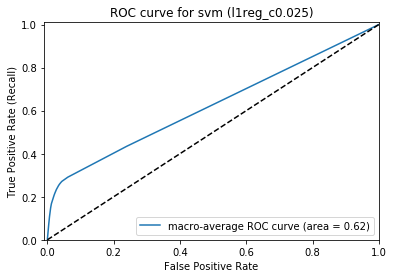

 done.

Decision Tree l1reg_c0.025
Running grid search on Decision Tree...
 Best param: {'min_samples_split': 10}
 Accuracy:   0.3338
 done.

Random Forest l1reg_c0.025


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
hyper_params = {
    'l1reg_c0.025':         {'lr': {'C': 0.25}, 'svm': {'C': 0.01},
                            'dt': { 'min_samples_split': 10}}, 
    'l1reg_c0.05':          {'lr': {'C': 0.25}, 'svm': {'C': 0.01},
                            'dt': {'min_samples_split': 10}}, 
    'l1reg_c0.1':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01},
                            'dt': {'min_samples_split': 5}}, 
    'l1reg_c0.25':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01},
                             'dt': {'min_samples_split': 5}}, 
    'l1reg_c0.5':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01},
                            'dt': {'min_samples_split': 10}},
    'l1reg_c1':             {'lr': {'C': 0.25}, 'svm': {'C': 0.01},
                            'dt': {'min_samples_split': 10}},
    'l1reg_c10':            {'lr': {'C': 0.1},  'svm': {'C': 0.01},
                            'dt': {'min_samples_split': 10}},
    'l1reg_c100':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01},
                            'dt': {'min_samples_split': 2}},
    
    'top_100_genes':        {'lr': {'C': 0.1},  'svm': {'C': 0.01}, 
                             'dt': {'min_samples_split': 3}},
    
   

    'bestfit_100':          {'lr': {'C': 0.1 }, 'svm': {'C': 0.01},
                            'dt':  {'min_samples_split': 10}},
    'bestfit_800':          {'lr': {'C': 0.1 }, 'svm': {'C': 0.01},
                            'dt':  {'min_samples_split': 10}},
    'bestfit_4000':         {'dt': {'min_samples_split': 3}},

    'bestfit_8000':         {'dt': {'min_samples_split': 5}},
    
    'all':                  {'lr': {'C': 0.25}, 'svm': {'C': 0.01}, 
                             'dt': {'min_samples_split': 3}},
    
    'all_patient':          {'lr': {'C': 0.25}, 'svm': {'C': 0.01}, 
                             'dt': {'min_samples_split': 3}},
    
    
    'after_pca':            {'lr': {'C': 0.5 }, 'svm': {'C': 0.01},
                            'dt': {'min_samples_split': 3}},
    
    'after_rf':             {'dt': {'min_samples_split': 3}},
    
    'rfe_100':              {'lr': {'C': 0.5},  'svm': {'C': 0.1},
                            'dt': {'min_samples_split': 3}}, 

    'rfe_800':              {'lr': {'C': 0.5},  'svm': {'C': 0.1},
                            'dt': {'min_samples_split': 3}}, 
    
    'rfe_4000':             {'lr': {'C': 0.1},  'svm': {'C': 0.01},
                            'dt': {'min_samples_split': 3}}, 
    
    'rfe_8000':             {'lr': {'C': 0.25}, 'svm': {'C': 0.01}, 
                            'dt': {'min_samples_split': 3}}
}


metrics = get_saved_metrics()


for name in all_train_data.keys():
    print("************************")
    print(name)
    print("************************")

    train      = all_train_data[name]
    test       = all_test_data[name]
    
    

    run_logistic_regression(train['data'], train['labels'], test['data'], test['labels'], 
                            name, hyper_params, metrics, forcerun=False)
    
    run_linear_svm(train['data'], train['labels'], test['data'], test['labels'], 
                   name, hyper_params, metrics, forcerun=False)

    run_decision_tree(train['data'], train['labels'], test['data'], test['labels'], 
                   name, hyper_params, metrics)
    
    run_random_forest(train['data'], train['labels'], test['data'], test['labels'], 
                   name, hyper_params, metrics)
    
    run_neural_net(train['data'], train['labels'], test['data'], test['labels'], 
                   name, hyper_params, metrics)
    
    